In [8]:
%cd /Users/Pia/Desktop/NLP/LDA

/Users/Pia/Desktop/NLP/LDA


In [2]:
import pandas as pd

In [37]:

d = pd.read_csv(r"LIWCPosLabel.csv")
print(d[0:10])

    A                                                  B  WC  Analytic  Clout  \
0   0           #ThingsDoneByMistake kissing auntie lips   4     38.60  99.00   
1   8  NickTomaWBRE  Nick  holding  Miners  Trump ral...   9     93.26  50.00   
2  18                 mikefdupjourney shenutt  welcome     3     93.26  99.00   
3  22   TrumpSuperPAC #AfricanAmericans like JermonMa...  13     97.95  50.00   
4  23   AmericanWoman #MAGA#FEMININEAMERICATRUMP#LGBT...  12     93.26  50.00   
5  25   HoofHearted TuckerCarlson\nJRubinBlogger #Big...  12     81.63  79.76   
6  31   heal Proof  Mainstream Media  Become  Joke [W...   9     93.26  50.00   
7  34   justenoughtrope  turns  come join  party Plus...  10     93.26  97.69   
8  36  Trump appears  encourage  owners  take action ...  10     93.26  97.69   
9  39  Obama  Trump winning Anything possible  #politics   6     62.04  50.00   

   Authentic  Tone  WPS  Sixltr     Dic  ...  SemiC  QMark  Exclam  Dash  \
0       1.00  99.0    4   50.00 

In [6]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

d['Processed_Reviews'] = d.B.apply(lambda x: clean_text(x))

In [11]:
d.Processed_Reviews.apply(lambda x: len(x.split(" "))).mean()


11.309035464250455

In [9]:
max_features = 6000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(d['Processed_Reviews'])
list_tokenized_train = tokenizer.texts_to_sequences(d['Processed_Reviews'])


NameError: name 'Tokenizer' is not defined

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

max_features = 6000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(d['Processed_Reviews'])
list_tokenized_train = tokenizer.texts_to_sequences(d['Processed_Reviews'])

maxlen = 130
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
y = d['Positive']

embed_size = 128
model = Sequential()
model.add(Embedding(max_features, embed_size))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 100
epochs = 3
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Using TensorFlow backend.


NameError: name 'd' is not defined

In [11]:


from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [12]:
dataframe = pd.read_csv(r"LIWCPosLabel.csv")

In [13]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

270316 train examples
67579 validation examples
84474 test examples


In [14]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('Troll')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [15]:
# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

In [11]:
feature_columns = []
# numeric cols
for header in ['WC', 'Analytic', 'Clout', 'Authentic', 'Tone', 'WPS', 'Sixltr', 'Dic', 'SemiC']:
  feature_columns.append(feature_column.numeric_column(header))


In [12]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [13]:
batch_size = 50
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [14]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Train on 5407 steps, validate on 1352 steps
Epoch 1/10
5407/5407 [==============================] - 171s 32ms/step - loss: 0.3747 - acc: 0.8365 - val_loss: 0.3288 - val_acc: 0.8553
Epoch 2/10
5407/5407 [==============================] - 49s 9ms/step - loss: 0.3308 - acc: 0.8555 - val_loss: 0.3039 - val_acc: 0.8704
Epoch 3/10
5407/5407 [==============================] - 47s 9ms/step - loss: 0.3094 - acc: 0.8685 - val_loss: 0.3029 - val_acc: 0.8728
Epoch 4/10
5407/5407 [==============================] - 47s 9ms/step - loss: 0.3021 - acc: 0.8722 - val_loss: 0.2934 - val_acc: 0.8754
Epoch 5/10
5407/5407 [==============================] - 47s 9ms/step - loss: 0.2968 - acc: 0.8748 - val_loss: 0.2873 - val_acc: 0.8809
Epoch 6/10
5407/5407 [==============================] - 48s 9ms/step - loss: 0.2939 - acc: 0.8768 - val_loss: 0.2854 - val_acc: 0.8802
Epoch 7/10
5407/5407 [==============================] - 49s 9ms/step - loss: 0.2913 - acc: 0.8774 - val_loss: 0.2849 - val_acc: 0.8821
Epoch 8/1

In [15]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

1690/1690 [==============================] - 51s 30ms/step - loss: 0.2861 - acc: 0.8785
Accuracy 0.8785425


### Just with tone: 

In [16]:
feature_columns = []
# numeric cols
for header in ['Tone']:
  feature_columns.append(feature_column.numeric_column(header))

In [17]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [18]:
batch_size = 50
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [19]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Train on 5407 steps, validate on 1352 steps
Epoch 1/10
5407/5407 [==============================] - 235s 43ms/step - loss: 0.7021 - acc: 0.5051 - val_loss: 0.6998 - val_acc: 0.5049
Epoch 2/10
5407/5407 [==============================] - 49s 9ms/step - loss: 0.6929 - acc: 0.5068 - val_loss: 0.6922 - val_acc: 0.5135
Epoch 3/10
5407/5407 [==============================] - 43s 8ms/step - loss: 0.6924 - acc: 0.5074 - val_loss: 0.6923 - val_acc: 0.5054
Epoch 4/10
5407/5407 [==============================] - 42s 8ms/step - loss: 0.6924 - acc: 0.5044 - val_loss: 0.6923 - val_acc: 0.5054
Epoch 5/10
5407/5407 [==============================] - 43s 8ms/step - loss: 0.6924 - acc: 0.5042 - val_loss: 0.6923 - val_acc: 0.5054
Epoch 6/10
5407/5407 [==============================] - 43s 8ms/step - loss: 0.6924 - acc: 0.5054 - val_loss: 0.6923 - val_acc: 0.5049
Epoch 7/10
5407/5407 [==============================] - 42s 8ms/step - loss: 0.6924 - acc: 0.5058 - val_loss: 0.6922 - val_acc: 0.5054
Epoch 8/1

In [20]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

1690/1690 [==============================] - 79s 47ms/step - loss: 0.6925 - acc: 0.5029
Accuracy 0.5028648


### Just with authenticity 

In [21]:
feature_columns = []
# numeric cols
for header in ['Authentic']:
  feature_columns.append(feature_column.numeric_column(header))

In [22]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [23]:
batch_size = 50
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [24]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Train on 5407 steps, validate on 1352 steps
Epoch 1/10
5407/5407 [==============================] - 284s 53ms/step - loss: 0.6910 - acc: 0.5602 - val_loss: 0.6812 - val_acc: 0.5733
Epoch 2/10
5407/5407 [==============================] - 50s 9ms/step - loss: 0.6815 - acc: 0.5711 - val_loss: 0.6847 - val_acc: 0.5617
Epoch 3/10
5407/5407 [==============================] - 43s 8ms/step - loss: 0.6799 - acc: 0.5753 - val_loss: 0.6785 - val_acc: 0.5845
Epoch 4/10
5407/5407 [==============================] - 43s 8ms/step - loss: 0.6787 - acc: 0.5772 - val_loss: 0.6775 - val_acc: 0.5743
Epoch 5/10
5407/5407 [==============================] - 46s 9ms/step - loss: 0.6783 - acc: 0.5757 - val_loss: 0.6774 - val_acc: 0.5732
Epoch 6/10
5407/5407 [==============================] - 44s 8ms/step - loss: 0.6780 - acc: 0.5755 - val_loss: 0.6768 - val_acc: 0.5732
Epoch 7/10
5407/5407 [==============================] - 49s 9ms/step - loss: 0.6778 - acc: 0.5752 - val_loss: 0.6770 - val_acc: 0.5809
Epoch 8/1

In [25]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

1690/1690 [==============================] - 119s 71ms/step - loss: 0.6762 - acc: 0.5774
Accuracy 0.57744396


### Words caputed by dictionary 

In [26]:
feature_columns = []
# numeric cols
for header in ['Dic']:
  feature_columns.append(feature_column.numeric_column(header))

In [27]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [28]:
batch_size = 50
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [29]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Train on 5407 steps, validate on 1352 steps
Epoch 1/10
5407/5407 [==============================] - 357s 66ms/step - loss: 0.6782 - acc: 0.5746 - val_loss: 0.6846 - val_acc: 0.5910
Epoch 2/10
5407/5407 [==============================] - 43s 8ms/step - loss: 0.6603 - acc: 0.5940 - val_loss: 0.6607 - val_acc: 0.5934
Epoch 3/10
5407/5407 [==============================] - 43s 8ms/step - loss: 0.6574 - acc: 0.5970 - val_loss: 0.6556 - val_acc: 0.6101
Epoch 4/10
5407/5407 [==============================] - 40s 7ms/step - loss: 0.6566 - acc: 0.5991 - val_loss: 0.6562 - val_acc: 0.6013
Epoch 5/10
5407/5407 [==============================] - 41s 8ms/step - loss: 0.6564 - acc: 0.5997 - val_loss: 0.6548 - val_acc: 0.6009
Epoch 6/10
5407/5407 [==============================] - 42s 8ms/step - loss: 0.6555 - acc: 0.6009 - val_loss: 0.6545 - val_acc: 0.6101
Epoch 7/10
5407/5407 [==============================] - 40s 7ms/step - loss: 0.6534 - acc: 0.6018 - val_loss: 0.6513 - val_acc: 0.6144
Epoch 8/1

In [30]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

1690/1690 [==============================] - 123s 73ms/step - loss: 0.6449 - acc: 0.6191
Accuracy 0.6191491


### Just Clout

*** "Higher Clout score is marked by using more we-words and social words and fewer I-words, negations (e.g., no, not), and swear words." ***

Weiai Xu and Congcong Zhang in Sentiment, richness, authority, and relevance modelof information sharing during social Crises—the case of #MH370 tweets

In [25]:
feature_columns = []
# numeric cols
for header in ['Clout']:
  feature_columns.append(feature_column.numeric_column(header))

In [26]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [27]:
batch_size = 50
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [28]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Train on 5407 steps, validate on 1352 steps
Epoch 1/10
5407/5407 [==============================] - 260s 48ms/step - loss: 0.5846 - acc: 0.7075 - val_loss: 0.5485 - val_acc: 0.7291
Epoch 2/10
5407/5407 [==============================] - 50s 9ms/step - loss: 0.5451 - acc: 0.7390 - val_loss: 0.5403 - val_acc: 0.7486
Epoch 3/10
5407/5407 [==============================] - 48s 9ms/step - loss: 0.5392 - acc: 0.7481 - val_loss: 0.5405 - val_acc: 0.7501
Epoch 4/10
5407/5407 [==============================] - 45s 8ms/step - loss: 0.5378 - acc: 0.7486 - val_loss: 0.5349 - val_acc: 0.7489
Epoch 5/10
5407/5407 [==============================] - 44s 8ms/step - loss: 0.5369 - acc: 0.7495 - val_loss: 0.5346 - val_acc: 0.7505
Epoch 6/10
5407/5407 [==============================] - 45s 8ms/step - loss: 0.5358 - acc: 0.7496 - val_loss: 0.5331 - val_acc: 0.7505
Epoch 7/10
5407/5407 [==============================] - 45s 8ms/step - loss: 0.5321 - acc: 0.7499 - val_loss: 0.5247 - val_acc: 0.7507
Epoch 8/1

In [29]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

1690/1690 [==============================] - 95s 56ms/step - loss: 0.5321 - acc: 0.7624
Accuracy 0.76240027


### Combination: Clout and Tone


In [30]:
feature_columns = []
# numeric cols
for header in ['Clout', 'Tone']:
  feature_columns.append(feature_column.numeric_column(header))


In [31]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

batch_size = 50
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Train on 5407 steps, validate on 1352 steps
Epoch 1/10
5407/5407 [==============================] - 348s 64ms/step - loss: 0.5771 - acc: 0.7159 - val_loss: 0.5519 - val_acc: 0.7258
Epoch 2/10
5407/5407 [==============================] - 49s 9ms/step - loss: 0.5472 - acc: 0.7383 - val_loss: 0.5369 - val_acc: 0.7479
Epoch 3/10
5407/5407 [==============================] - 46s 8ms/step - loss: 0.5369 - acc: 0.7472 - val_loss: 0.5330 - val_acc: 0.7579
Epoch 4/10
5407/5407 [==============================] - 45s 8ms/step - loss: 0.5270 - acc: 0.7512 - val_loss: 0.5316 - val_acc: 0.7531
Epoch 5/10
5407/5407 [==============================] - 47s 9ms/step - loss: 0.5210 - acc: 0.7533 - val_loss: 0.5176 - val_acc: 0.7541
Epoch 6/10
5407/5407 [==============================] - 48s 9ms/step - loss: 0.5181 - acc: 0.7556 - val_loss: 0.5200 - val_acc: 0.7555
Epoch 7/10
5407/5407 [==============================] - 49s 9ms/step - loss: 0.5169 - acc: 0.7565 - val_loss: 0.5171 - val_acc: 0.7540
Epoch 8/1

In [32]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

1690/1690 [==============================] - 122s 72ms/step - loss: 0.5152 - acc: 0.7614
Accuracy 0.7614059


### Combi Clout and Authenticity 

In [33]:
feature_columns = []
# numeric cols
for header in ['Clout', 'Authentic']:
  feature_columns.append(feature_column.numeric_column(header))


In [34]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

batch_size = 50
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Train on 5407 steps, validate on 1352 steps
Epoch 1/10
5407/5407 [==============================] - 392s 72ms/step - loss: 0.5818 - acc: 0.7112 - val_loss: 0.5444 - val_acc: 0.7376
Epoch 2/10
5407/5407 [==============================] - 49s 9ms/step - loss: 0.5465 - acc: 0.7333 - val_loss: 0.5380 - val_acc: 0.7430
Epoch 3/10
5407/5407 [==============================] - 45s 8ms/step - loss: 0.5354 - acc: 0.7398 - val_loss: 0.5275 - val_acc: 0.7443
Epoch 4/10
5407/5407 [==============================] - 46s 8ms/step - loss: 0.5320 - acc: 0.7429 - val_loss: 0.5282 - val_acc: 0.7439
Epoch 5/10
5407/5407 [==============================] - 44s 8ms/step - loss: 0.5296 - acc: 0.7450 - val_loss: 0.5276 - val_acc: 0.7432
Epoch 6/10
5407/5407 [==============================] - 44s 8ms/step - loss: 0.5252 - acc: 0.7500 - val_loss: 0.5198 - val_acc: 0.7552
Epoch 7/10
5407/5407 [==============================] - 44s 8ms/step - loss: 0.5212 - acc: 0.7556 - val_loss: 0.5201 - val_acc: 0.7549
Epoch 8/1

In [35]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

1690/1690 [==============================] - 154s 91ms/step - loss: 0.5282 - acc: 0.7584
Accuracy 0.75837535


### Combi: Authentic, tone and clout 

In [36]:
feature_columns = []
# numeric cols
for header in ['Clout', 'Authentic', "Tone"]:
  feature_columns.append(feature_column.numeric_column(header))


In [37]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

batch_size = 50
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Train on 5407 steps, validate on 1352 steps
Epoch 1/10
5407/5407 [==============================] - 557s 103ms/step - loss: 0.5758 - acc: 0.7153 - val_loss: 0.5464 - val_acc: 0.7391
Epoch 2/10
5407/5407 [==============================] - 50s 9ms/step - loss: 0.5417 - acc: 0.7376 - val_loss: 0.5335 - val_acc: 0.7439
Epoch 3/10
5407/5407 [==============================] - 45s 8ms/step - loss: 0.5299 - acc: 0.7465 - val_loss: 0.5222 - val_acc: 0.7470
Epoch 4/10
5407/5407 [==============================] - 47s 9ms/step - loss: 0.5200 - acc: 0.7542 - val_loss: 0.5109 - val_acc: 0.7583
Epoch 5/10
5407/5407 [==============================] - 44s 8ms/step - loss: 0.5149 - acc: 0.7573 - val_loss: 0.5133 - val_acc: 0.7519
Epoch 6/10
5407/5407 [==============================] - 48s 9ms/step - loss: 0.5122 - acc: 0.7584 - val_loss: 0.5070 - val_acc: 0.7614
Epoch 7/10
5407/5407 [==============================] - 45s 8ms/step - loss: 0.5098 - acc: 0.7590 - val_loss: 0.5084 - val_acc: 0.7579
Epoch 8/

In [38]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

1690/1690 [==============================] - 206s 122ms/step - loss: 0.5086 - acc: 0.7605
Accuracy 0.7604707


### Just analytic 

In [8]:
feature_columns = []
# numeric cols
for header in ['Analytic']:
  feature_columns.append(feature_column.numeric_column(header))

feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

batch_size = 50
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5407 steps, validate on 1352 steps
Epoch 1/10
5407/5407 [==============================] - 71s 13ms/step - loss: 0.7107 - acc: 0.5079 - val_loss: 0.6923 - val_acc: 0.5253
Epoch 2/10
5407/5407 [==============================] - 51s 9ms/step - loss: 0.6933 - acc: 0.5164 - val_loss: 0.6908 - val_acc: 0.5311
Epoch 3/10
5407/5407 [==============================] - 50s 9ms/step - loss: 0.6915 - acc: 0.5205 - val_loss: 0.6904 - val_acc: 0.5366
Epoch 4/10
5407/5407 [==============================] - 52s 10ms/step - loss: 0.6908 - acc: 0.5253 - val_loss: 0.6898 - val_acc: 0.5311
Epoch 5/10
5407/5407 [==============================] - 51s 9ms/step - loss: 0.6903 - acc: 0.5259 - val_loss: 0.6897 - val_acc: 0.5379
Epoch 6/10
5407/5407 [==============================] - 44s 8ms/step - loss: 0.6901 - acc: 0.5252 - val_

In [9]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

1690/1690 [==============================] - 18s 11ms/step - loss: 0.6904 - acc: 0.5258
Accuracy 0.5258068


### Just WPS 

In [34]:
feature_columns = []
# numeric cols
for header in ['WPS']:
  feature_columns.append(feature_column.numeric_column(header))

feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

batch_size = 50
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Train on 5407 steps, validate on 1352 steps
Epoch 1/10
5407/5407 [==============================] - 468s 87ms/step - loss: 0.4551 - acc: 0.7551 - val_loss: 0.4354 - val_acc: 0.7726
Epoch 2/10
5407/5407 [==============================] - 52s 10ms/step - loss: 0.4334 - acc: 0.7682 - val_loss: 0.4350 - val_acc: 0.7659
Epoch 3/10
5407/5407 [==============================] - 47s 9ms/step - loss: 0.4320 - acc: 0.7690 - val_loss: 0.4279 - val_acc: 0.7705
Epoch 4/10
5407/5407 [==============================] - 45s 8ms/step - loss: 0.4314 - acc: 0.7691 - val_loss: 0.4287 - val_acc: 0.7726
Epoch 5/10
5407/5407 [==============================] - 45s 8ms/step - loss: 0.4308 - acc: 0.7696 - val_loss: 0.4272 - val_acc: 0.7726
Epoch 6/10
5407/5407 [==============================] - 45s 8ms/step - loss: 0.4308 - acc: 0.7690 - val_loss: 0.4271 - val_acc: 0.7726
Epoch 7/10
5407/5407 [==============================] - 45s 8ms/step - loss: 0.4305 - acc: 0.7698 - val_loss: 0.4292 - val_acc: 0.7705
Epoch 8/

In [35]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

1690/1690 [==============================] - 191s 113ms/step - loss: 0.4323 - acc: 0.7663
Accuracy 0.7662713


### Just Sixltr 

In [16]:
feature_columns = []
# numeric cols
for header in ['Sixltr']:
  feature_columns.append(feature_column.numeric_column(header))

feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

batch_size = 50
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5407 steps, validate on 1352 steps
Epoch 1/10
5407/5407 [==============================] - 59s 11ms/step - loss: 0.5909 - acc: 0.6835 - val_loss: 0.5898 - val_acc: 0.6915
Epoch 2/10
5407/5407 [==============================] - 46s 9ms/step - loss: 0.5815 - acc: 0.6919 - val_loss: 0.5771 - val_acc: 0.6963
Epoch 3/10
5407/5407 [==============================] - 64s 12ms/step - loss: 0.5799 - acc: 0.6936 - val_loss: 0.5771 - val_acc: 0.6941
Epoch 4/10
5407/5407 [==============================] - 44s 8ms/step - loss: 0.5795 - acc: 0.6941 - val_loss: 0.5787 - val_acc: 0.6899
Epoch 5/10
5407/5407 [==============================] - 43s 8ms/step - loss: 0.5793 - acc: 0.6950 - val_loss: 0.5766 - val_acc: 0.6969
Epoch 6/10
5407/5407 [==============================] - 57s 11ms/step - loss: 0.5792 - acc: 0.6948 - val

In [17]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

1690/1690 [==============================] - 16s 9ms/step - loss: 0.5823 - acc: 0.6880
Accuracy 0.6879632


### Just SemiC

In [18]:
feature_columns = []
# numeric cols
for header in ['SemiC']:
  feature_columns.append(feature_column.numeric_column(header))

feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

batch_size = 50
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Train on 5407 steps, validate on 1352 steps
Epoch 1/10
5407/5407 [==============================] - 114s 21ms/step - loss: 0.6931 - acc: 0.5031 - val_loss: 0.6931 - val_acc: 0.5075
Epoch 2/10
5407/5407 [==============================] - 47s 9ms/step - loss: 0.6931 - acc: 0.5034 - val_loss: 0.6930 - val_acc: 0.5075
Epoch 3/10
5407/5407 [==============================] - 49s 9ms/step - loss: 0.6931 - acc: 0.5037 - val_loss: 0.6930 - val_acc: 0.5075
Epoch 4/10
5407/5407 [==============================] - 45s 8ms/step - loss: 0.6931 - acc: 0.5034 - val_loss: 0.6931 - val_acc: 0.5075
Epoch 5/10
5407/5407 [==============================] - 51s 9ms/step - loss: 0.6931 - acc: 0.5034 - val_loss: 0.6930 - val_acc: 0.5075
Epoch 6/10
5407/5407 [==============================] - 45s 8ms/step - loss: 0.6931 - acc: 0.5035 - val_loss: 0.6930 - val_acc: 0.5075
Epoch 7/10
5407/5407 [==============================] - 48s 9ms/step - loss: 0.6931 - acc: 0.5037 - val_loss: 0.6930 - val_acc: 0.5075
Epoch 8/1

In [19]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

1690/1690 [==============================] - 36s 21ms/step - loss: 0.6931 - acc: 0.5051
Accuracy 0.505114


In [20]:
Data = {'Features':['WC Analytic Clout Authentic Tone WPS Sicltr Dic SemiC', 'Tone', 'Authentic', 'Dic', "Clout", "Clout Tone", "Clout Authentic", "Clout Authentic Tone", "Analytic", "WPS", "Sixltr", "SemiC"], 'Accuracy':[0.8785425, 0.5028648, 0.5784, 0.6191491, 0.76240027, 0.5258068, 0.7614059, 0.75837535, 0.5258068, 0.7662713, 0.6879632, 0.505114]} 

df = pd.DataFrame(Data)

print(df)

                                             Features  Accuracy
0   WC Analytic Clout Authentic Tone WPS Sicltr Di...  0.878543
1                                                Tone  0.502865
2                                           Authentic  0.578400
3                                                 Dic  0.619149
4                                               Clout  0.762400
5                                          Clout Tone  0.525807
6                                     Clout Authentic  0.761406
7                                Clout Authentic Tone  0.758375
8                                            Analytic  0.525807
9                                                 WPS  0.766271
10                                             Sixltr  0.687963
11                                              SemiC  0.505114


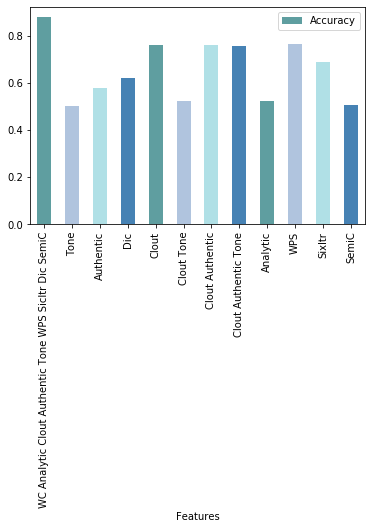

In [21]:
import matplotlib.pyplot as plt

df.plot(x ='Features', y='Accuracy', kind = 'bar', color=['CadetBlue', 'LightSteelBlue', 'PowderBlue', 'SteelBlue'])


